### 6 m is mean nitricline depth and just below 10% light level

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import glob
import datetime as dt
from salishsea_tools import viz_tools
from matplotlib.ticker import FormatStrFormatter
import cmocean
from salishsea_tools import viz_tools, evaltools as et
import NorthNut as nn
import matplotlib.gridspec as gridspec
import pickle
import matplotlib as mpl
import matplotlib.patheffects as path_effects
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

NorthNut defined variables: ig0,ig1,jg0,jg1,fformat0
NorthNut defined variables: vmask, vmask0, umask, umask0, tmask, fmask, gdept,  gdept_1d, e1t, e2t, e12t, e1f, e2f, e1v, e2u, e3t_1d
NorthNut defined variables: boxCol, colL, colR, arrowwidth, headwidth, headlength, alen, toff, apw, apk


In [2]:
ig0=nn.ig0
ig1=nn.ig1
jg0=nn.jg0
jg1=nn.jg1
tmask=nn.tmask
umask=nn.umask
vmask=nn.vmask
umask0=nn.umask0
vmask0=nn.vmask0
boxCol=nn.boxCol
colL=nn.colL
colR=nn.colR

In [3]:
e12t=nn.e12t

In [4]:
k=6 #depth presented here
k1=30 # max depth to do calcs to
start=dt.datetime(2016,5,15) # originally 5/15-8/15,  but changed to even number of fortnights (6, end is included)
end=dt.datetime(2016,8,20)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_nam_fmt='nowcast'
mod_flen=1
saveloc='/data/eolson/results/MEOPAR/SS36runs/calcFiles/NTransport/'
fver='HC201812'

made interval a multiple of a fortnight in attempt to minimize aliasing of tidal cycle:

In [5]:
# calc transports: boxes in full model coords
boxes,boxesS=nn.defboxes(k)

volumes: 
(40, 130, 97)
0 vol: 232834007.16923195 m3
0 north face area: 0.017903174399708822 km2
0 south face area: 0.023887115963210383 km2
0 east face area: 0.0 km2
0 floor area: 38.10316762126778 km2
0 floor area: 38.10316762126778 km2
(40, 130, 97)
1 vol: 475501033.2591236 m3
1 north face area: 0.051981996171633744 km2
1 south face area: 0.0660928789851366 km2
1 east face area: 0.04443908484818648 km2
1 floor area: 76.65649877674242 km2
1 floor area: 76.65649877674242 km2
(40, 130, 97)
2 vol: 467855857.4262955 m3
2 north face area: 0.0660928789851366 km2
2 south face area: 0.058877382444252245 km2
2 east face area: 0.044474769797453136 km2
2 floor area: 76.13281888160705 km2
2 floor area: 76.13281888160705 km2
(40, 130, 97)
3 vol: 475349561.3011287 m3
3 north face area: 0.0691002936013758 km2
3 south face area: 0.05633497645148102 km2
3 east face area: 0.044501987470235926 km2
3 floor area: 77.68207812856889 km2
3 floor area: 77.68207812856889 km2
(40, 130, 97)
4 vol: 460253674.339

In [6]:
flistV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_V',1)
flistU=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_U',1)
flistW=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'dian_W',1)
flistC=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'carp_T',1)
flistT=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
flistP=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)
flistGV=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_V',1)
flistGU=et.index_model_files(start,end,mod_basedir,mod_nam_fmt,mod_flen,'grid_U',1)

ftype=dian_V, are you sure? (if yes, add to list)
ftype=dian_U, are you sure? (if yes, add to list)
ftype=dian_W, are you sure? (if yes, add to list)


In [7]:
NBound, SBound, EBound, BBound, NBoundMix, SBoundMix, EBoundMix, BBoundMix, Content, Vol, A_N, A_S, A_E, times, boxes = nn.calcTransps(
    start,end,k1,mod_flen,fver,saveloc,boxes,boxesS,flistV,flistU,flistW,flistC,flistT,recalc=False)

In [8]:
# vertical transport into 4th box
np.shape(BBound[3])

(2352, 30)

In [9]:
meanT, meanM = nn.calcFluxFields(flistV,flistU,flistW,flistC,k,saveloc,start,end,fver,recalc=False)

In [10]:
recalc=False
fformat0='%Y%m%d'
savepathT=saveloc+'saveVolTransp_'+fver+'_k'+str(k)+'_'+start.strftime(fformat0)+\
                                                               '-'+end.strftime(fformat0)+'.pkl'
# calc mean velocities upper k
if recalc==True:
    VT_i=np.zeros((len(flistGV)*24,jg1-jg0,ig1-ig0))
    UT_i=np.zeros((len(flistGV)*24,jg1-jg0,ig1-ig0))
    for iif in range(0,len(flistGV)):
        with nc.Dataset(flistGV.loc[iif,['paths']].values[0]) as fv, \
              nc.Dataset(flistGU.loc[iif,['paths']].values[0]) as fu, \
                nc.Dataset(flistC.loc[iif,['paths']].values[0]) as fc:
            e3te=fc.variables['e3t'][:,:k,jg0:jg1,ig0:ig1]
            VTe=np.sum(0.5*(fv.variables['vomecrty'][:,:k,(jg0-1):(jg1-1),ig0:ig1]+fv.variables['vomecrty'][:,:k,jg0:jg1,ig0:ig1])*e3te,1)
            UTe=np.sum(0.5*(fu.variables['vozocrtx'][:,:k,jg0:jg1,(ig0-1):(ig1-1)]+fu.variables['vozocrtx'][:,:k,jg0:jg1,ig0:ig1])*e3te,1)
        VT_i[(iif*24):(iif*24+24),:,:]=VTe
        UT_i[(iif*24):(iif*24+24),:,:]=UTe
    mVT=np.mean(VT_i,0)
    mUT=np.mean(UT_i,0)
    fformat0='%Y%m%d'
    pickle.dump({'mVT':mVT,'mUT':mUT},open(savepathT,'wb'))
else:
    data=pickle.load(open(savepathT,'rb'))
    mVT=data['mVT']
    mUT=data['mUT']

In [11]:
recalc=False
savepathV=saveloc+'saveVel_'+fver+'_k'+str(k)+'_'+start.strftime(fformat0)+\
                                                               '-'+end.strftime(fformat0)+'.pkl'
# calc mean velocities upper k
if recalc==True:
    V_i=np.zeros((len(flistGV)*24,jg1-jg0,ig1-ig0))
    U_i=np.zeros((len(flistGV)*24,jg1-jg0,ig1-ig0))
    for iif in range(0,len(flistGV)):
        with nc.Dataset(flistGV.loc[iif,['paths']].values[0]) as fv, \
              nc.Dataset(flistGU.loc[iif,['paths']].values[0]) as fu, \
                nc.Dataset(flistC.loc[iif,['paths']].values[0]) as fc:
            e3te=fc.variables['e3t'][:,:k,jg0:jg1,ig0:ig1]
            Ve=np.sum(0.5*(fv.variables['vomecrty'][:,:k,(jg0-1):(jg1-1),ig0:ig1]+fv.variables['vomecrty'][:,:k,jg0:jg1,ig0:ig1])*e3te,1)/np.sum(e3te,1)
            Ue=np.sum(0.5*(fu.variables['vozocrtx'][:,:k,jg0:jg1,(ig0-1):(ig1-1)]+fu.variables['vozocrtx'][:,:k,jg0:jg1,ig0:ig1])*e3te,1)/np.sum(e3te,1)
        V_i[(iif*24):(iif*24+24),:,:]=Ve
        U_i[(iif*24):(iif*24+24),:,:]=Ue
    mV=np.mean(V_i,0)
    mU=np.mean(U_i,0)
    fformat0='%Y%m%d'
    pickle.dump({'mV':mV,'mU':mU},open(savepathV,'wb'))
else:
    data=pickle.load(open(savepathV,'rb'))
    mV=data['mV']
    mU=data['mU']

In [12]:
mapCol=(0.67, 0.8, 0.64) # rgb
cmb=cmocean.tools.crop_by_percent(cmocean.cm.balance, 45, which='both', N=None)
cmb.set_bad(mapCol)
cmc=cmocean.tools.crop_by_percent(cmocean.cm.tarn_r, 40, which='both', N=None)
cmc.set_bad(mapCol)

In [13]:
for el in BBound.keys():
    print(el,np.mean(np.sum(BBound[el][:,:k]+BBoundMix[el][:,:k],1))*1e-3)

0 106.68687299579294
1 67.73938469636559
2 -91.42046017658305
3 61.87491918843877
4 2.664297754196007
5 41.0880141843993


#### Sum of vertical mixing and transport NO3 supply to region in boxes:

In [14]:
np.mean(np.sum(BBound[0][:,:k]+BBoundMix[0][:,:k]+\
               BBound[1][:,:k]+BBoundMix[1][:,:k]+\
               BBound[2][:,:k]+BBoundMix[2][:,:k]+\
               BBound[3][:,:k]+BBoundMix[3][:,:k]+\
               BBound[4][:,:k]+BBoundMix[4][:,:k]+\
               BBound[5][:,:k]+BBoundMix[5][:,:k],1))*1e-3

188.63302864260956

##### Divide by area:

In [15]:
ABoxes=nn.boxAreas(k)

volumes: 
(40, 130, 97)
0 vol: 232834007.16923195 m3
0 north face area: 0.017903174399708822 km2
0 south face area: 0.023887115963210383 km2
0 east face area: 0.0 km2
0 floor area: 38.10316762126778 km2
0 floor area: 38.10316762126778 km2
(40, 130, 97)
1 vol: 475501033.2591236 m3
1 north face area: 0.051981996171633744 km2
1 south face area: 0.0660928789851366 km2
1 east face area: 0.04443908484818648 km2
1 floor area: 76.65649877674242 km2
1 floor area: 76.65649877674242 km2
(40, 130, 97)
2 vol: 467855857.4262955 m3
2 north face area: 0.0660928789851366 km2
2 south face area: 0.058877382444252245 km2
2 east face area: 0.044474769797453136 km2
2 floor area: 76.13281888160705 km2
2 floor area: 76.13281888160705 km2
(40, 130, 97)
3 vol: 475349561.3011287 m3
3 north face area: 0.0691002936013758 km2
3 south face area: 0.05633497645148102 km2
3 east face area: 0.044501987470235926 km2
3 floor area: 77.68207812856889 km2
3 floor area: 77.68207812856889 km2
(40, 130, 97)
4 vol: 460253674.339

In [16]:
# units are umol/m2/s
Asum=ABoxes[0]+ABoxes[1]+ABoxes[2]+ABoxes[3]+ABoxes[4]+ABoxes[5]
np.mean(np.sum(BBound[0][:,:k]+BBoundMix[0][:,:k]+\
               BBound[1][:,:k]+BBoundMix[1][:,:k]+\
               BBound[2][:,:k]+BBoundMix[2][:,:k]+\
               BBound[3][:,:k]+BBoundMix[3][:,:k]+\
               BBound[4][:,:k]+BBoundMix[4][:,:k]+\
               BBound[5][:,:k]+BBoundMix[5][:,:k],1))/Asum*1e3

0.44670356730227306

In [17]:
NBoundC, SBoundC, EBoundC, BBoundC, NBoundMixC, SBoundMixC, EBoundMixC, BBoundMixC = \
    nn.transpConversions(boxes,NBound,SBound,EBound,BBound,NBoundMix,SBoundMix,EBoundMix,BBoundMix,k)

units now mol/s
0
9.947443564164551 -35.36731480236245 0.0
-0.0046223353959914375 58.76628758233049 0.0
1
-22.620420567817963 2.780912185800212 -4.152702975741998
-0.003609745963443457 26.68507539825033 0.01654148305007088
2
-48.21118237454796 -38.53446231146092 -5.828905089609929
0.020290641983787206 10.629639434866348 0.022566290148021577
3
-15.233859569173294 16.33758039802773 0.9471348725929473
0.010119958992957822 3.7240321789910458 0.023437269926385562
4
-23.81655244968974 -3.282389513837408 -0.7069941837524848
5.932767951691176e-06 2.8153398651808828 0.01571380403468441
5
-15.806420454157982 9.432231135160077 3.7878209498426956
0.01883030837182633 3.2020627328984146 0.011968896304912286


In [18]:
BBoundC

{0: -35.36731480236245,
 1: 2.780912185800212,
 2: -38.53446231146092,
 3: 16.33758039802773,
 4: -3.282389513837408,
 5: 9.432231135160077}

In [19]:
mask=dict()
mask['V']=vmask0
mask['U']=umask0
mask['W']=tmask[k,:,:]

In [26]:
# NBoundC:
for el in NBoundC:
    print(el,NBoundC[el])

0 9.947443564164551
1 -22.620420567817963
2 -48.21118237454796
3 -15.233859569173294
4 -23.81655244968974
5 -15.806420454157982


In [27]:
# SBoundC:
for el in SBoundC:
    print(el,SBoundC[el])

0 -10.705207468296186
1 -48.21118237454796
2 -17.121361889061724
3 -23.95515532538627
4 -14.44589312680721
5 -14.68694807880987


In [32]:
-22.620420567817963+10.705207468296186

-11.915213099521777

In [33]:
-17.121361889061724+15.233859569173294

-1.88750231988843

In [34]:
-23.95515532538627+23.81655244968974

-0.1386028756965274

In [35]:
-15.806420454157982+14.44589312680721

-1.3605273273507716

In [29]:
# EBoundC:
for el in EBoundC:
    print(el,EBoundC[el])

0 0.0
1 -4.152702975741998
2 -5.828905089609929
3 0.9471348725929473
4 -0.7069941837524848
5 3.7878209498426956


In [30]:
# BBoundC:
for el in BBoundC:
    print(el,BBoundC[el])

0 -35.36731480236245
1 2.780912185800212
2 -38.53446231146092
3 16.33758039802773
4 -3.282389513837408
5 9.432231135160077


In [31]:
# BBoundMIXC:
for el in BBoundMixC:
    print(el,BBoundMixC[el])

0 58.76628758233049
1 26.68507539825033
2 10.629639434866348
3 3.7240321789910458
4 2.8153398651808828
5 3.2020627328984146


/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/Ntransports_k6_2016.pdf


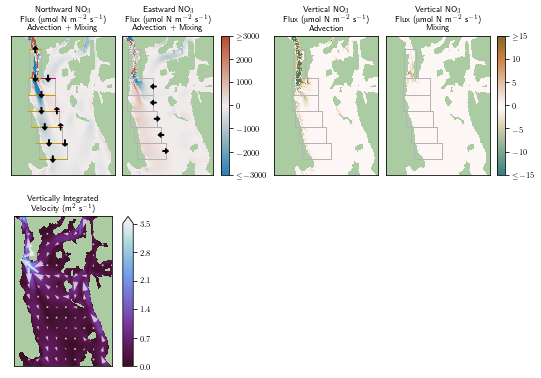

In [20]:
fig=plt.figure(figsize=(7.5,5.2))
gs0=gridspec.GridSpec(2,2,hspace=0.24,wspace=.13,left=.01,right=.93,bottom=.022,top=.92,
                      width_ratios=[1,1],height_ratios=[1,1])
ax=list()
cbax=list()
for jx in range(0,2):
    if jx==0:
        gsi=gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,jx],
                                         width_ratios=[10,10*(ig1-ig0-.5)/(ig1-ig0+13),11-10*(ig1-ig0-.5)/(ig1-ig0+13)],wspace=.1)
        gsl=gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1,jx],
                                         width_ratios=[10,10,1],wspace=.1)
    elif jx==1:
        gsi=gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,jx],
                                         width_ratios=[10,10,1],wspace=.1)
        gsl2=gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1,jx],
                                         width_ratios=[10,10,1],wspace=.1)
    ax1=fig.add_subplot(gsi[0])
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    viz_tools.set_aspect(ax1)
    ax2=fig.add_subplot(gsi[1])
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    viz_tools.set_aspect(ax2)
    ax3=fig.add_subplot(gsi[2])
    ax.append(ax1,)
    ax.append(ax2,)
    cbax.append(ax3,)

ax7=fig.add_subplot(gsl[0])
viz_tools.set_aspect(ax7)
ax9=fig.add_subplot(gsl[2])
ax.append(ax3,)
ax.append(ax3,)
ax.append(ax7,)
cbax.append(ax9,)
cbax.append(ax9,)

v1=3000
m=ax[0].pcolormesh(np.ma.masked_where(mask['V']==0,1000*(meanT['V']+meanM['V'])),cmap=cmb,vmin=-1*v1,vmax=v1)
ax[0].set_title('Northward NO$_3$\nFlux ($\muup$mol N m$^{-2}$ s$^{-1}$)\nAdvection + Mixing')
m=ax[1].pcolormesh(np.ma.masked_where(mask['U']==0,1000*(meanT['U']+meanM['U'])),cmap=cmb,vmin=-1*v1,vmax=v1)
cb0=fig.colorbar(m,cax=cbax[0])
ax[1].set_title('Eastward NO$_3$\nFlux ($\muup$mol N m$^{-2}$ s$^{-1}$)\nAdvection + Mixing')
v2=15
m=ax[2].pcolormesh(np.ma.masked_where(mask['W']==0,1000*(meanT['W'])),cmap=cmc,vmin=-1*v2,vmax=v2)
ax[2].set_title('Vertical NO$_3$\nFlux ($\muup$mol N m$^{-2}$ s$^{-1}$)\nAdvection')
m=ax[3].pcolormesh(np.ma.masked_where(mask['W']==0,1000*(meanM['W'])),cmap=cmc,vmin=-1*v2,vmax=v2)
cb1=fig.colorbar(m,cax=cbax[1])
ax[3].set_title('Vertical NO$_3$\nFlux ($\muup$mol N m$^{-2}$ s$^{-1}$)\nMixing')

nn.drawboxesV(ax[0],boxes,boxCol)
nn.drawboxesU(ax[1],boxes,boxCol)
nn.drawboxesT(ax[2],boxes,boxCol)
nn.drawboxesT(ax[3],boxes,boxCol)
for iax in ax:
    iax.set_facecolor(mapCol)
ax[0].set_xlim(-13,ig1-ig0)
ax[1].set_xlim(0,ig1-ig0-.5)
ax[2].set_xlim(-13,ig1-ig0)
ax[3].set_xlim(-13,ig1-ig0)

ax[0].set_ylim(.5,jg1-jg0-.5)
ax[1].set_ylim(1,jg1-jg0)
ax[2].set_ylim(1,jg1-jg0)
ax[3].set_ylim(1,jg1-jg0)

nn.annotYTranspUpper(ax[0],boxes,NBoundC,SBoundC,NBoundMixC,SBoundMixC)
nn.annotXTranspUpper(ax[1],boxes,EBoundC,EBoundMixC)
nn.annotWTTranspUpper(ax[2],boxes,BBoundC)
nn.annotWMTranspUpper(ax[3],boxes,BBoundMixC)

x1=ax[1].get_position()
xc1=cbax[0].get_position()
cbax[0].set_position(mpl.transforms.Bbox.from_bounds(xc1.bounds[0],x1.bounds[1],.015,x1.bounds[3]))
x2=ax[3].get_position()
xc2=cbax[1].get_position()
cbax[1].set_position(mpl.transforms.Bbox.from_bounds(xc2.bounds[0],x2.bounds[1],.015,x2.bounds[3]))

fig.canvas.draw()
for icb in (cb0,cb1):
    test=icb.ax.yaxis.get_ticklabels()
    test[0].set_text('$\leq$'+(test[0].get_text()))
    test[-1].set_text('$\geq$'+(test[-1].get_text()))
    icb.ax.yaxis.set_ticklabels(test)

cm0=cmocean.cm.thermal
cm0.set_bad(mapCol)
cm1=cmocean.cm.dense_r
cm1.set_bad(mapCol)



iax=ax[6]
ii0=6
#log scale arrow magnitude without ruining vector directions:
clim=(0,3.5)
subN=9
sh=np.shape(mUT)#mUT
shx,shy=np.meshgrid(np.arange(ii0,sh[1],subN),np.arange(ii0,sh[0],subN))
#log scale arrow magnitude without ruining vector directions:
ugrd=mUT
vgrd=mVT
mesh=iax.contourf(np.ma.masked_where(tmask[0,:,:]==0,
    np.sqrt(ugrd[:,:]**2+vgrd[:,:]**2)),
    np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],cmap=cm1,extend='max')
mag0=np.sqrt(ugrd**2+vgrd**2)
ugrd2=np.ma.masked_where(tmask[0,:,:]==0,ugrd)#np.where(mag0==0,0,ugrd*mag2/mag0))
vgrd2=np.ma.masked_where(tmask[0,:,:]==0,vgrd)#np.where(mag0==0,0,vgrd*mag2/mag0))
Q = iax.quiver(shx,shy,ugrd2[ii0::subN, ii0::subN], vgrd2[ii0::subN, ii0::subN],
                               pivot='mid', units='inches',width=.03,color='w',scale=7,alpha=.7)#scale=4000
iax.set_title('Vertically Integrated\nVelocity (m$^2$ s$^{-1}$)')
iax.set_xticks([],[]);
iax.set_yticks([],[]);
cb=fig.colorbar(mesh,cax=cbax[3],ticks=np.linspace(clim[0],clim[1],6))
bb=cbax[3].get_position()
cbax[3].set_position([bb.x0-.205,bb.y0,bb.width,bb.height])
#p0=ax1.get_position()


fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/Ntransports_k'+str(k)+'_2016.png',dpi=300)
fig.savefig('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/Ntransports_k'+str(k)+'_2016.pdf',dpi=300)
print('/data/eolson/results/MEOPAR/biomodelevalpaper/figsNNut/Ntransports_k'+str(k)+'_2016.pdf')

### look at total upward N transports

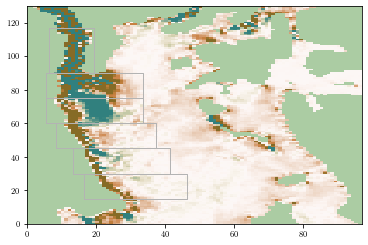

In [21]:
fig,ax=plt.subplots(1,1)
ax.pcolormesh(np.ma.masked_where(mask['W']==0,1000*(meanT['W']+meanM['W'])),
               cmap=cmc,vmin=-1,vmax=1)
nn.drawboxesV(ax,boxes,boxCol)

In [22]:
## total net N transport in moles N / s
np.sum(np.sum(np.ma.masked_where(mask['W']==0,1000*(meanT['W']+meanM['W'])*e12t),1),0)*1e-6


127.6871104591957

In [23]:
## total net N transport in moles N / s
np.sum(np.sum(np.ma.masked_where(mask['W'][:-3,:]==0,1000*(meanT['W'][:-3,:]+meanM['W'][:-3,:])*e12t[:-3,:]),1),0)*1e-6


168.39301931623206

##### divide both by area:

In [24]:
# whole range, umol/m2/s
np.sum(np.sum(np.ma.masked_where(mask['W']==0,1000*(meanT['W']+meanM['W'])*e12t),1),0)/np.sum(np.sum(e12t*mask['W']))

0.08035357186492066

In [25]:
# cut off 3, umol/m2/s
np.sum(np.sum(np.ma.masked_where(mask['W'][:-3,:]==0,1000*(meanT['W'][:-3,:]+meanM['W'][:-3,:])*e12t[:-3,:]),1),0)/np.sum(np.sum(e12t[:-3,:]*mask['W'][:-3,:]))

0.1071077246273401